In [1]:
import torch           #导入pyTorch库
import torch.nn as nn  #torch.nn提供搭建网络所需要的组件

#torchvision是PyTorch官方提供的用于计算机视觉的库，提供了一些经典网络的实现和公开数据集
#torchvision.datasets下是一些公开数据集
from torchvision import datasets

# torchvision.transforms下是一些常见的图片处理可调用对象，
#如ToTensor可将图片从数组(二维矩阵）转换为Tensor，Resize可对图片进行缩放，RandomCrop可进行随机剪切

#图片需要转换为张量才能输入网络，PyTorch要求图片张量的维度为[channel,height,width],
#与普通图片维度[height,width，channel]不同，需要使用 transforms.ToTensor()来完成
from torchvision import transforms

#由于计算机内存和显存有限，一般分批次传入数据，可用torch.utils.data.DataLoader来实现
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 制作数据集

# 数据预处理，设定下载参数
#使用transforms.Compose()函数设置预处理的方式
#transforms.ToTensor()将图像数据转为张量，且调整三个维度的顺序为 C*H*W
#transforms.Normalize数据的标准化处理，将神经网络的输入数据转化为标准正态分布，训练更好；
#根据统计计算，MNIST 训练集所有像素的均值是 0.1307、标准差是 0.3081。
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
])

# 下载训练集与测试集
#第一个参数指定数据集下载并保存的目标文件夹；train=Ture表示加载训练数据集；
#download=Ture,代表使用这个函数自动下载MNIST数据集；（自动检测目标文件夹内是否有，如果没有进行下载）
#transform的设置代表使用刚定义的数据预处理方法
train_Data = datasets.MNIST(
    root = 'D:\Jupyter\深度学习(4)：深度神经网络（DNN）',
    train = True, 
    download = True, 
    transform = transform
)
test_Data = datasets.MNIST(
    root = 'D:\Jupyter\深度学习(4)：深度神经网络（DNN）',
    train = False, 
    download = True, 
    transform = transform
)

In [4]:
# 批次加载器，，由于计算机内存和显存有限，一般分批次传入数据
# shuffle是否在每个epoch之前对数据进行洗牌（随机打乱顺序），以增加样本的随机性和训练的效果。

train_loader = DataLoader(train_Data, shuffle=True, batch_size=64)
test_loader  = DataLoader(test_Data, shuffle=False, batch_size=64)

In [5]:
# 第二步.构建神经网络
# 在PyTorch中构建神经网络需要自定义继承torch.nn.Module类，并重写forward（）方法
# 以nn.Module作为父类，我们自己的神经网络可直接继承父类的方法与属性，nn.Module中包含网络各个层的定义

#在定义的神经网络的子类中，__init__()特殊方法用于构造自己的神经网络结构，定义需要使用的层，
#forward()方法用于将输入数据进行前向传播；由于张量可以自动计算梯度，所以不需要出现反向传播
class DNN(nn.Module):

    def __init__(self):
        ''' 搭建神经网络各层 '''
# super(DNN, self).init()的作用是调用父类的构造函数，用于初始化继承自父类的属性和方法。
# 这样做的目的是为了确保在子类中可以继承父类的行为和特性，并实现子类自身的定制化功能。
# nn.Sequential()函数用于构建一个包含多个神经网络模块的序列模型。
# 通过将不同的神经网络模块按顺序添加到Sequential中，可以便捷地构建复杂的神经网络结构
        super(DNN,self).__init__()
        self.net = nn.Sequential(            # 按顺序搭建各层
            nn.Flatten(),                    # 先把图像铺平成一维
            nn.Linear(784, 512), nn.ReLU(),  # 第1层：全连接层，后接激活函数
            nn.Linear(512, 256), nn.ReLU(),  # 第2层：全连接层
            nn.Linear(256, 128), nn.ReLU(),  # 第3层：全连接层
            nn.Linear(128, 64),  nn.ReLU(),  # 第4层：全连接层
            nn.Linear(64, 10),               # 第5层：全连接层
        )

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)        # x即输入数据
        return y               # y即输出数据

In [6]:
model = DNN()#.to('cuda:0')    # 创建子类的实例，并搬到GPU上
model                         # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [7]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss()    # 自带softmax激活函数

In [8]:
# 优化算法的选择
# 给优化器了一个新参数momentum（动量），它使梯度下降算法有了力与惯性
learning_rate = 0.01    # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr = learning_rate, 
    momentum = 0.5
)

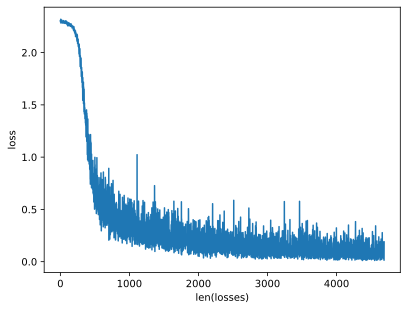

In [10]:
# 训练网络
epochs = 5
# 列表由若干有序的变量组成，用中括号表示，
losses = []        # 记录损失函数变化的列表,

for epoch in range(epochs):
    
# for (x, y) in train_loader:是一个循环结构，用于遍历一个数据集中的样本
# 在深度学习中，我们通常会使用循环来遍历数据集，并将每个批次的输入数据和标签数据输入到神经网络中进行训练
     for (x, y) in train_loader:                  # 获取小批次的x与y
#       x, y = x.to('cuda:0'), y.to('cuda:0')    # 把小批次搬到GPU上
        Pred = model(x)                          # 一次前向传播（小批量）
        loss = loss_fn(Pred, y)                  # 计算损失函数
        
# loss.item()是将PyTorch中的损失张量转换为Python的标量，.append()是一个列表对象的方法，
# 用于在列表的末尾添加一个新元素，利用append()方法将该标量值添加到名为losses的列表中,
        losses.append(loss.item())               # 记录损失函数的变化
    
# 在优化器调用.step前应调用optimmizer.zero_grad()清空上一轮梯度，
# 调用loss.backward()计算梯度，再调用optimizer.step()优化参数    
        optimizer.zero_grad()                    # 清理上一轮滞留的梯度
        loss.backward()                          # 一次反向传播
        optimizer.step()                         # 优化内部参数
        
# 将损失函数值存储在列表losses中的每个元素作为y值，对应的训练步数索引作为x值，
# 然后绘制出随着训练步数的增加，损失函数值的变化趋势
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.ylabel('loss')
plt.xlabel('len(losses)')
plt.show()

In [11]:
len(losses)

4690

In [12]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():                                   # 该局部关闭梯度计算功能
    for (x, y) in test_loader:                          # 获取小批次的x与y
#       x, y = x.to('cuda:0'), y.to('cuda:0')           # 把小批次搬到GPU上
        Pred = model(x)                                 # 一次前向传播（小批量）
    
# a, b = torch.max(Pred.data, dim=1)的意思是，找出Pred 每一行里的最大值，数值赋给a，所处位置赋给b。
# 因此上述代码里的predicted 就相当于把独热编码转换回了普通的阿拉伯数字，这样一来可以直接与y 进行比较。
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 96.87000274658203 %
